# Train a VAE on L1000 Data

In [1]:
import sys
import pathlib
import numpy as np
import pandas as pd

sys.path.insert(0, "../../scripts")
from utils import load_data, infer_L1000_features
import matplotlib.pyplot as plt

from tensorflow import keras


from vae import VAE
from tensorflow.keras.models import Model, Sequential
import seaborn
import tensorflow as tf

In [14]:
# %load_ext nb_black

In [15]:
# np.random.seed(123)
# python_random.seed(123)
# tf.random.set_random_seed(1234)

In [3]:
data_splits = ["train", "valid", "test", "complete"]
# data_splits = ["train", "valid","test"]
data_dict = load_data(data_splits, dataset="L1000")
# data_dict["train"] = data_dict["train"][data_dict["train"].cell_id == "A549"].reset_index(drop = True)
# data_dict["valid"] = data_dict["valid"][data_dict["valid"].cell_id == "A549"].reset_index(drop = True)
# data_dict["test"] = data_dict["test"][data_dict["test"].cell_id == "A549"].reset_index(drop = True)
# data_dict["complete"] = data_dict["complete"][data_dict["complete"].cell_id == "A549"].reset_index(drop = True)

In [5]:
# Prepare data for training

# meta_features = infer_L1000_features(data_dict["train"], metadata=True)
# profile_features = infer_L1000_features(data_dict["train"])

train_features_df = data_dict["train"]
# train_meta_df = data_dict["train"].reindex(meta_features, axis="columns")

valid_features_df = data_dict["valid"]
# valid_meta_df = data_dict["valid"].reindex(meta_features, axis="columns")

test_features_df = data_dict["test"]
# test_meta_df = data_dict["test"].reindex(meta_features, axis="columns")

complete_features_df = data_dict["complete"]
# complete_meta_df = data_dict["complete"].reindex(meta_features, axis="columns")

In [18]:
#shuffle columns
def shuffle_each_column(df):
    columns = df.columns
    df_copy = df.copy()
    for column in columns:
        df_copy[column] = df_copy[column].sample(frac=1).reset_index(drop=True)
    return (df_copy)

In [19]:
# train_features_df = shuffle_each_column(train_features_df)
# valid_features_df = shuffle_each_column(valid_features_df)
# test_features_df = shuffle_each_column(test_features_df)

In [6]:
print(train_features_df.shape)
train_features_df.head(3)

(22269, 978)


,200814_at,222103_at,201453_x_at,204131_s_at,200059_s_at,205067_at,213702_x_at,214435_x_at,201334_s_at,213721_at,...,204662_at,203047_at,203343_at,217995_at,218450_at,212536_at,218529_at,211071_s_at,203341_at,205379_at
0,0.30437,-0.10339,0.63448,-0.39331,0.079844,-0.80388,0.13444,0.000254,-0.42435,-0.37067,...,-0.19088,-0.80277,0.87668,0.071645,-0.14151,-0.578780,0.42060,0.24091,0.45441,0.091703
1,-0.25459,-0.21991,0.66226,-0.14261,-0.142470,-0.55282,0.05843,0.203910,-0.71007,-0.33036,...,-0.17936,-0.71162,0.77875,0.253750,-0.31596,-0.510950,0.21092,0.12414,0.16320,-0.391840
2,0.24722,-0.12555,0.61333,-0.48051,0.015259,-0.69824,0.13981,-0.019656,-0.47722,-0.46956,...,-0.22896,-0.79984,0.83013,0.079528,-0.20354,-0.011039,0.39238,0.15747,0.11056,0.072443


In [7]:
print(valid_features_df.shape)
valid_features_df.head(3)

(2784, 978)


,200814_at,222103_at,201453_x_at,204131_s_at,200059_s_at,205067_at,213702_x_at,214435_x_at,201334_s_at,213721_at,...,204662_at,203047_at,203343_at,217995_at,218450_at,212536_at,218529_at,211071_s_at,203341_at,205379_at
0,0.25286,-0.07951,0.57340,-0.48979,0.074880,-0.80004,0.134600,0.015865,-0.37698,-0.46565,...,-0.19911,-0.82942,0.84849,0.207770,-0.12148,-0.61075,0.30168,-0.025526,0.18524,0.019278
1,0.27019,-0.12932,0.63259,-0.48010,0.011367,-0.74222,0.039202,-0.019551,-0.51953,-0.42523,...,-0.17918,-0.78606,0.79581,0.059597,-0.11880,-0.52634,0.32392,0.296420,0.12044,0.099980
2,0.24610,-0.11851,0.60524,-0.52326,0.012125,-0.71059,0.085973,-0.038837,-0.45260,-0.42172,...,-0.17677,-0.79229,0.86686,-0.011163,-0.10610,-0.53383,0.35349,0.013662,0.20283,-0.003609


In [8]:
print(test_features_df.shape)
test_features_df.head(3)

(2784, 978)


,200814_at,222103_at,201453_x_at,204131_s_at,200059_s_at,205067_at,213702_x_at,214435_x_at,201334_s_at,213721_at,...,204662_at,203047_at,203343_at,217995_at,218450_at,212536_at,218529_at,211071_s_at,203341_at,205379_at
0,0.31828,-0.12730,0.61988,-0.49565,-0.091100,-0.63468,0.104580,0.084656,-0.53265,-0.35414,...,-0.22408,-0.79425,0.84078,0.016669,0.125250,-0.48914,0.33019,0.27093,0.19219,0.010105
1,0.41224,-0.11336,0.58426,-0.43285,0.030228,-0.78070,0.099171,0.038311,-0.41573,-0.47872,...,-0.25160,-0.85796,0.87369,0.124470,-0.125100,-0.68549,0.40614,0.30510,0.16373,0.090410
2,0.28812,-0.13146,0.56826,-0.44934,0.059876,-0.74244,0.025040,0.047477,-0.60509,-0.43410,...,-0.23674,-0.77894,0.86686,0.230360,-0.086595,-0.55438,0.42244,0.30036,0.19623,0.047084


In [9]:
print(complete_features_df.shape)
complete_features_df.head(3)

(27837, 978)


,200814_at,222103_at,201453_x_at,204131_s_at,200059_s_at,205067_at,213702_x_at,214435_x_at,201334_s_at,213721_at,...,204662_at,203047_at,203343_at,217995_at,218450_at,212536_at,218529_at,211071_s_at,203341_at,205379_at
0,0.30217,-0.147260,0.60254,-0.47207,-0.006505,-0.64092,0.077337,0.046284,-0.44848,-0.46813,...,-0.22349,-0.81964,0.85217,0.073042,-0.36807,-0.62511,0.11574,0.22250,0.22492,0.049422
1,0.24025,-0.097232,0.57689,-0.51428,-0.114330,-0.77363,0.041709,-0.081453,-0.49015,-0.52093,...,-0.18953,-0.68756,0.43662,0.083220,-0.18968,-0.17644,0.37470,0.21429,0.22280,-0.046527
2,0.22771,-0.145300,0.62270,-0.54280,0.038674,-0.78398,0.041709,0.035132,-0.43792,-0.48785,...,-0.22980,-0.85568,0.85217,0.043414,-0.31392,-0.58941,0.36700,0.29074,0.15431,0.102900


In [10]:
# VAE of one layer
# 100
encoder_architecture = [1000,1000]
decoder_architecture = [1000,1000]


In [11]:
# model from optimal hyperparameters for onelayer obtained from 1.optimize
L1000_vae = VAE(
    input_dim=train_features_df.shape[1],
    latent_dim=115,
    batch_size=640,
    encoder_batch_norm=False,
    epochs=50,
    learning_rate=0.001,
    encoder_architecture=encoder_architecture,
    decoder_architecture=decoder_architecture,
    beta=1,
    verbose=True,
)

#FROM THE PAPER
# L1000_vae = VAE(
#     input_dim=train_features_df.shape[1],
#     latent_dim=100,
#     batch_size=512,
#     encoder_batch_norm=False,
#     epochs=20,
#     learning_rate=0.001,
#     encoder_architecture=encoder_architecture,
#     decoder_architecture=decoder_architecture,
#     beta=1,
#     verbose=True,
# )

# L1000_vae = VAE(
#     input_dim=train_features_df.shape[1],
#     latent_dim=20,
#     batch_size=64,
#     encoder_batch_norm=False,
#     epochs=20,
#     learning_rate=0.001,
#     encoder_architecture=encoder_architecture,
#     decoder_architecture=decoder_architecture,
#     beta=1,
#     verbose=True,
# )
L1000_vae.compile_vae()


In [13]:
L1000_vae.train(x_train=train_features_df, x_test=valid_features_df)

Epoch 1/50
35/35 [==============================] - 2s 70ms/step - loss: 23.3527 - val_loss: 23.3428
Epoch 2/50
35/35 [==============================] - 2s 68ms/step - loss: 23.1625 - val_loss: 23.2222
Epoch 3/50
35/35 [==============================] - 2s 69ms/step - loss: 23.0230 - val_loss: 23.1676
Epoch 4/50
35/35 [==============================] - 2s 67ms/step - loss: 22.6834 - val_loss: 22.4776
Epoch 5/50
35/35 [==============================] - 2s 68ms/step - loss: 22.3738 - val_loss: 22.4280
Epoch 6/50
35/35 [==============================] - 2s 68ms/step - loss: 21.8548 - val_loss: 21.8684
Epoch 7/50
35/35 [==============================] - 2s 70ms/step - loss: 21.7523 - val_loss: 21.3443
Epoch 8/50
35/35 [==============================] - 2s 69ms/step - loss: 21.2360 - val_loss: 21.0548
Epoch 9/50
35/35 [==============================] - 2s 70ms/step - loss: 21.0086 - val_loss: 21.1484
Epoch 10/50
35/35 [==============================] - 2s 70ms/step - loss: 20.9733 - val_los

In [14]:
L1000_vae.vae

In [15]:
# Save training performance
history_df = pd.DataFrame(L1000_vae.vae.history.history)
history_df

,loss,val_loss
0,23.352690,23.342785
1,23.162460,23.222244
2,23.023045,23.167582
3,22.683384,22.477631
4,22.373850,22.427994
5,21.854767,21.868351
6,21.752312,21.344288
7,21.235994,21.054842
8,21.008644,21.148386
9,20.973257,21.164774


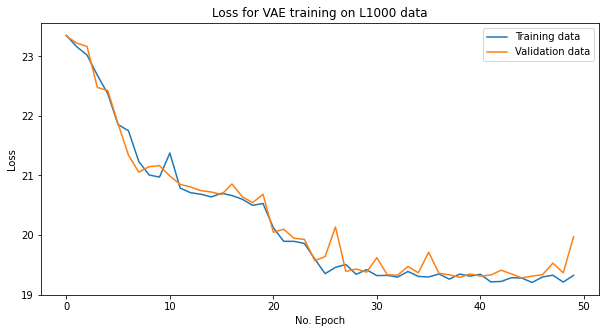

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(history_df["loss"], label="Training data")
plt.plot(history_df["val_loss"], label="Validation data")
plt.title("Loss for VAE training on L1000 data")
# plt.ylabel("Binary cross entropy + KL Divergence")
plt.ylabel("Loss")
plt.xlabel("No. Epoch")
plt.legend()
plt.show()

In [17]:
# evaluating performance using test set
L1000_vae.vae.evaluate(test_features_df)

87/87 [==============================] - 1s 4ms/step - loss: 20.0145


20.014497756958008

In [31]:
reconstruction = pd.DataFrame(
    L1000_vae.vae.predict(test_features_df), columns=profile_features
)
(sum(sum((np.array(test_features_df) - np.array(reconstruction)) ** 2))) ** 0.5

235.75794060847335

<AxesSubplot:>

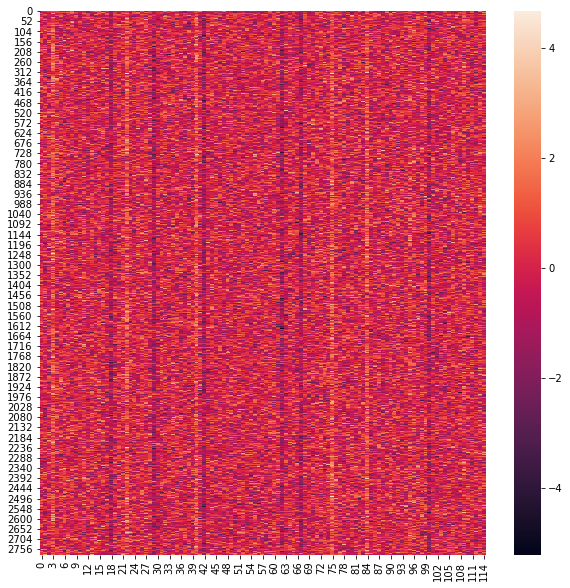

In [18]:
# latent space heatmap
fig, ax = plt.subplots(figsize=(10, 10))
encoder = L1000_vae.encoder_block["encoder"]
latent = np.array(encoder.predict(test_features_df)[2])
seaborn.heatmap(latent, ax=ax)

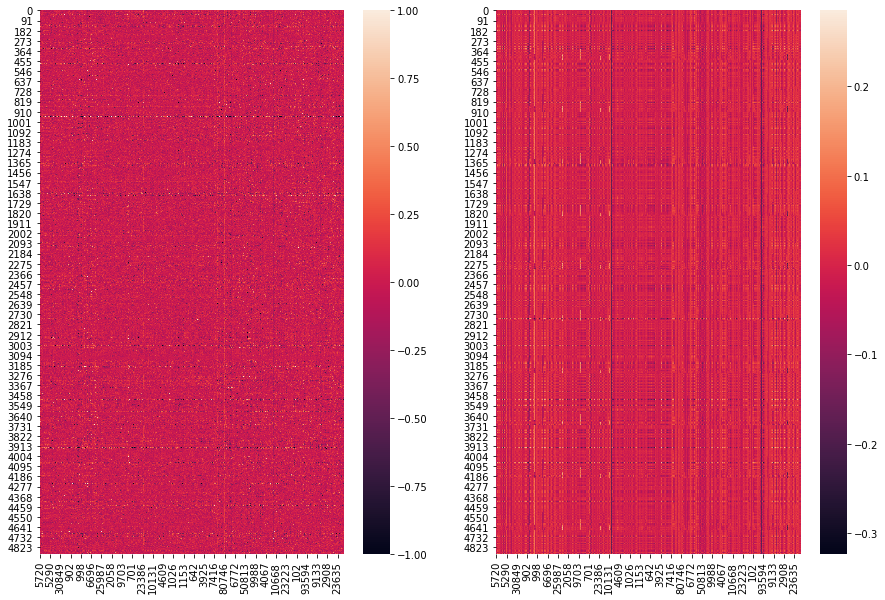

In [33]:
# original vs reconstructed heatmap
reconstruction = pd.DataFrame(
    L1000_vae.vae.predict(test_features_df), columns=profile_features
)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
seaborn.heatmap(test_features_df, ax=ax1)
seaborn.heatmap(reconstruction, ax=ax2)
plt.show()

<AxesSubplot:>

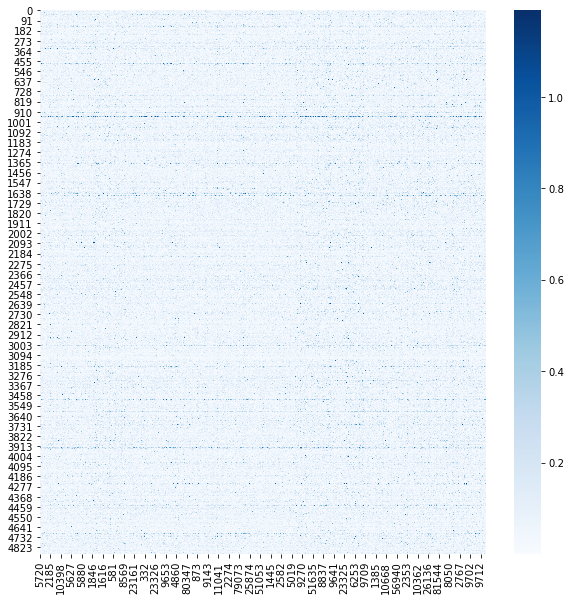

In [34]:
#difference between original and reconstructed heatmap
difference = abs(reconstruction - test_features_df)
fig, ax = plt.subplots(figsize=(10, 10))
seaborn.heatmap(difference, ax=ax, cmap="Blues")

<AxesSubplot:>

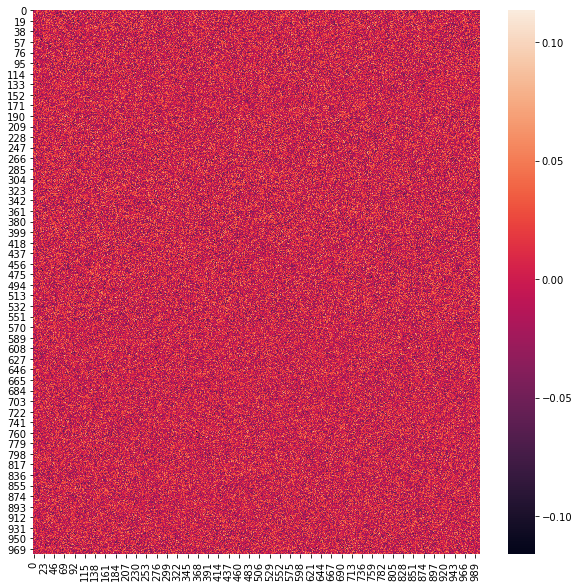

In [35]:
#encoder heatmap
weights = L1000_vae.encoder_block["encoder"].get_weights()
fig, ax = plt.subplots(figsize=(10, 10))
seaborn.heatmap(weights[0], ax=ax)

In [19]:
#NOTE: IF YOU RUN THIS, YOU WILL NOT BE ABLE TO REPRODUCE THE EXACT RESULTS IN THE EXPERIMENT
latent_complete = np.array(encoder.predict(complete_features_df)[2])
latent_df = pd.DataFrame(latent_complete)
latent_df.to_csv("../3.application/latent4.csv")

In [20]:
#NOTE: IF YOU RUN THIS, YOU WILL NOT BE ABLE TO REPRODUCE THE EXACT RESULTS IN THE EXPERIMENT
decoder = L1000_vae.decoder_block["decoder"]
decoder.save('./bottle')

INFO:tensorflow:Assets written to: ./bottle/assets
